In [3]:
import torchvision.transforms as tfs
from src.models.utils import download_checkpoint, load_model
from src.experiments import *
from src.experiments.utils import *
from src.visualization import *
from src.optimization import *
from src.optimization.parametrization import *
from IPython.display import Image 
from PIL import Image

size = (3, 224, 224)
device = "cuda" if torch.cuda.is_available() else 'cpu'

# torch.manual_seed(0)
# np.random.seed(0)

checkpoint_path = download_checkpoint("https://drive.google.com/file/d/19m_SaRNEF7JXHjeyNu26AxgaEQXqpI00", "protopnet.pt")
model = load_model('protopnet', checkpoint_path, device=device)

# Compositional Pattern Producing Network

https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb

\+ fourier features https://bmild.github.io/fourfeat/
(idea was to give more info than just coordinates by embedding it in fourier space, but makes images much worse i.e. creates high frequency noise)

code adapted from lucid
https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb

xor test stolen from lucid

64 64 torch.Size([1, 2, 64, 64])


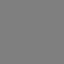

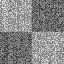

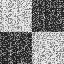

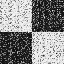

In [4]:
def xor_test(a):
    sq = torch.square
    return -(sq(a[...,:32,:32]).mean() + sq(a[...,32:,32:]).mean() + sq(1.0-a[...,32:,:32]).mean() + sq(1.0-a[...,:32,32:]).mean())

cppn = ImageCPPN(64, normalize=True, use_fourier_features=True).to(device)
cppn.grid = cppn.grid.to(device)
print(cppn.width, cppn.height, cppn.grid.shape)
optimizer = torch.optim.Adam(cppn.parameters(), lr=1e-3)

for i in range(150):
    optimizer.zero_grad()
    img = cppn()
    if i % 50 == 0:
        display(F.to_pil_image(img.squeeze(0)))
    loss = xor_test(img)
    loss.backward()
    optimizer.step()
img = cppn()
display(F.to_pil_image(img.squeeze(0)))

step: 0/1500, loss: -0.08748478442430496


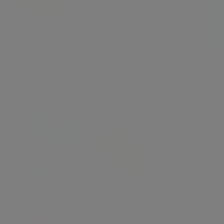

step: 500/1500, loss: -3.099492311477661


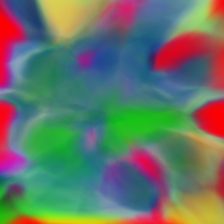

step: 1000/1500, loss: -3.593005895614624


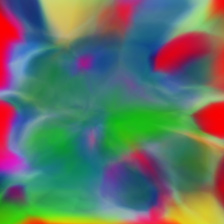

Optimized image:


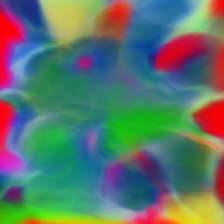

In [14]:
from src.optimization.parametrization import *
from src.optimization.utils import *

def loss(model, image, mask):
    output = model(image)[mask]
    return -torch.mean(output)

gen = ImageCPPN(224, normalize=True).to(device)
gen.grid = gen.grid.to(device)

def parametrization(image):
    global gen
    return gen().squeeze(0)

transforms = []
robustness_transforms = []
parametrization_transforms = [
    tfs.Lambda(parametrization),
]
gradient_transforms = []
denormalization_transforms = []

ptypes = [(188,1)]

optimized_input = visualize_prototypes(model=model,
                                       prototypes_list=ptypes,
                                       loss_agg_fn=loss,
                                       input_tensor=torch.zeros(*size),
                                       optimizer_cls=torch.optim.Adam,
                                       optimizer_parameters=gen.parameters(),
                                       optimizer_kwargs={'lr': 0.001},
                                       optimization_steps=1500,
                                       transforms=transforms,
                                       robustness_transforms=robustness_transforms,
                                       parametrization_transforms=parametrization_transforms,
                                       gradient_transforms=gradient_transforms,
                                       denormalization_transforms=denormalization_transforms,
                                       reverse_reversible_robustness_transforms=False,
                                       print_interval=500,
                                       display_interval=500)
image = parametrization(optimized_input)

print('Optimized image:')
pilimg = F.to_pil_image(image)
display(pilimg)

# All prototypes of one class

==== (188, 0) ====


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


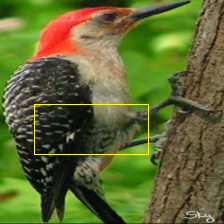

step: 0/500, loss: -0.16418814659118652


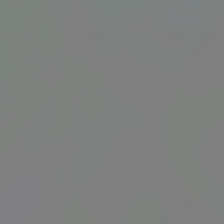

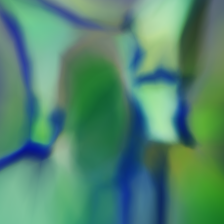

==== (188, 1) ====


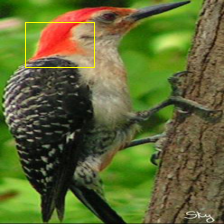

step: 0/500, loss: -0.08748478442430496


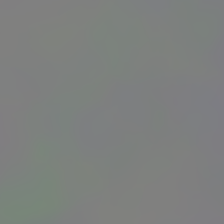

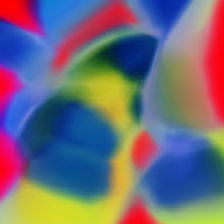

==== (188, 2) ====


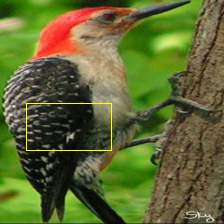

step: 0/500, loss: -0.17999385297298431


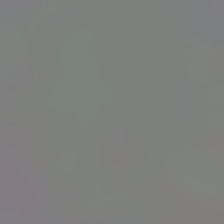

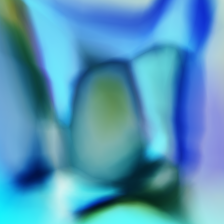

==== (188, 3) ====


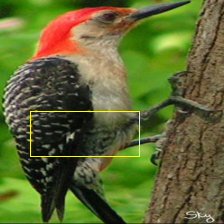

step: 0/500, loss: -0.1736498773097992


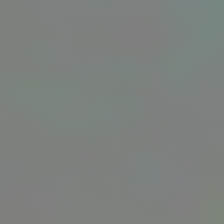

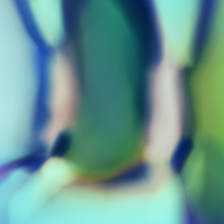

==== (188, 4) ====


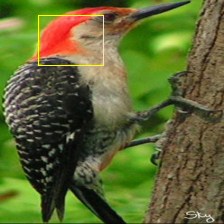

step: 0/500, loss: -0.07112839818000793


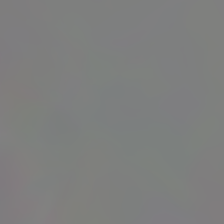

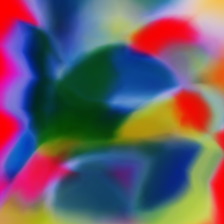

==== (188, 5) ====


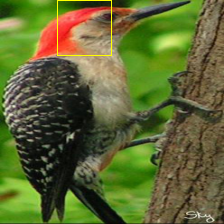

step: 0/500, loss: -0.04861646518111229


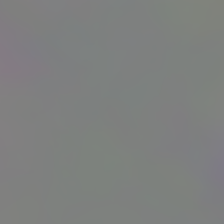

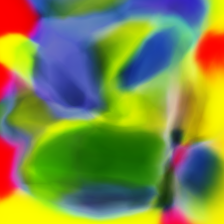

==== (188, 6) ====


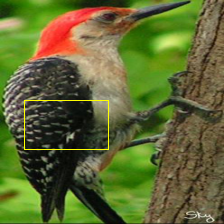

step: 0/500, loss: -0.1789971888065338


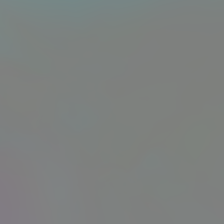

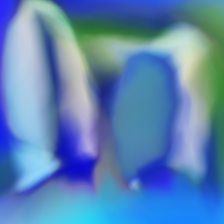

==== (188, 7) ====


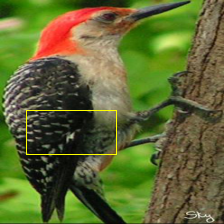

step: 0/500, loss: -0.17819799482822418


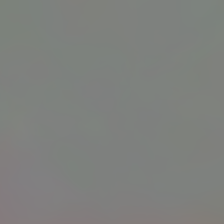

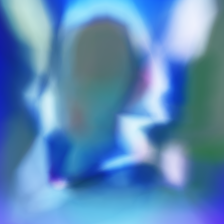

==== (188, 8) ====


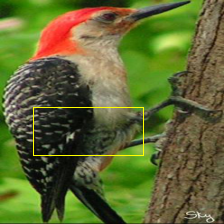

step: 0/500, loss: -0.1663949340581894


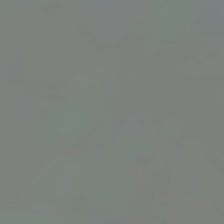

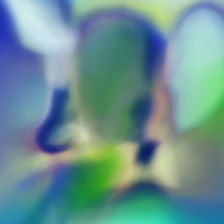

==== (188, 9) ====


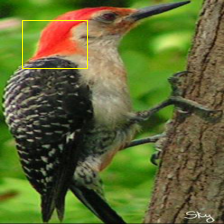

step: 0/500, loss: -0.08889244496822357


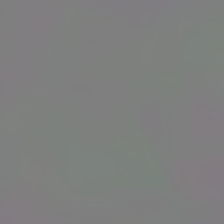

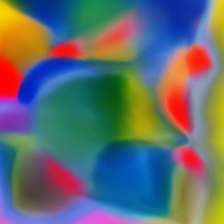

In [8]:
ptypes = [(188,i) for i in range(10)]
generators = [ImageCPPN(224, normalize=True).to(device) for i in range(10)]

def loss(model, image, mask):
    output = model(image)[mask]
    return -torch.mean(output)

transforms = []
robustness_transforms = []
gradient_transforms = []
denormalization_transforms = []

for g, p in zip(generators, ptypes):
    print('====', p, '====')
    img = visualize_real_prototype(model,"189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0002_180879.jpg" , p[0], p[1])
    display(img)
    parametrization_transforms = [tfs.Lambda(lambda _: g().squeeze(0))]
    optimized_input = visualize_prototypes(model=model,
                                        prototypes_list=[p],
                                        loss_agg_fn=loss,
                                        input_tensor=torch.zeros(*size),
                                        optimizer_cls=torch.optim.Adam,
                                        optimizer_parameters=g.parameters(),
                                        optimizer_kwargs={'lr': 0.005},
                                        optimization_steps=500,
                                        transforms=transforms,
                                        robustness_transforms=robustness_transforms,
                                        parametrization_transforms=parametrization_transforms,
                                        gradient_transforms=gradient_transforms,
                                        denormalization_transforms=denormalization_transforms,
                                        reverse_reversible_robustness_transforms=False,
                                        print_interval=500,
                                        display_interval=500)
    image = g().squeeze(0)
    display(F.to_pil_image(image))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([10, 3, 224, 224]) torch.Size([10, 3, 224, 224])


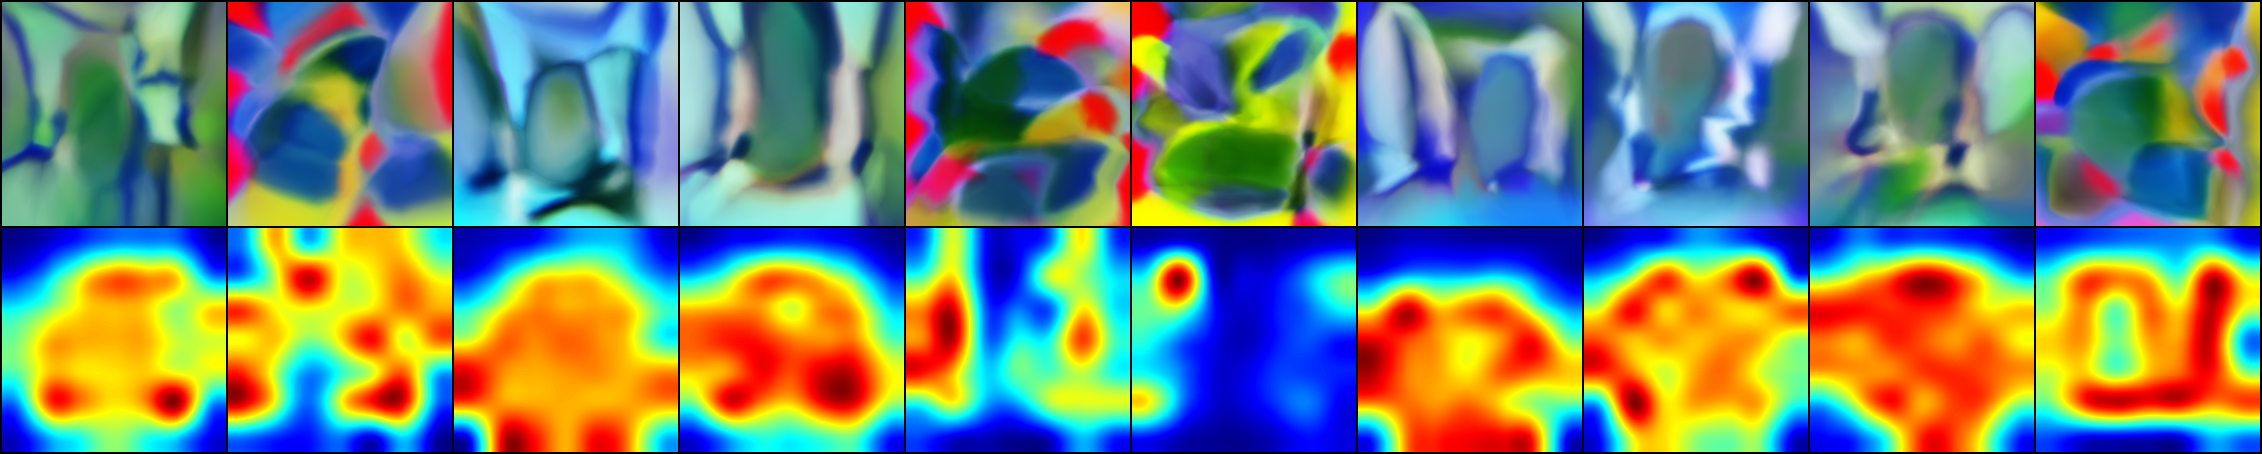

In [9]:
imgs = []
hmaps = []
for i, g in enumerate(generators):
    img = F.to_pil_image(g().squeeze(0))
    imgs.append(F.to_tensor(img))
    h = heatmap(model, img, 188, i, superimpose=False)
    hmaps.append(F.to_tensor(h))

from torchvision.utils import make_grid

imgs = torch.stack(imgs, dim=0)
hmaps = torch.stack(hmaps, dim=0)
print(imgs.shape, hmaps.shape)
display(F.to_pil_image(make_grid(torch.cat([imgs, hmaps], dim=0), nrow=10)))

# Different prototypes

==== (50, 0) ====


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


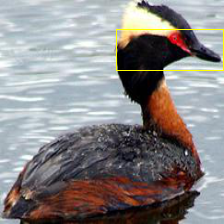

step: 0/500, loss: -0.07712496072053909


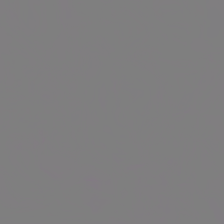

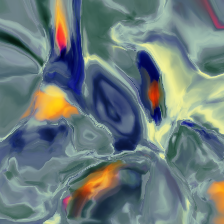

==== (100, 0) ====


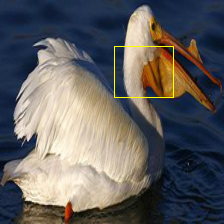

step: 0/500, loss: -0.05832629278302193


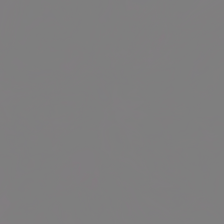

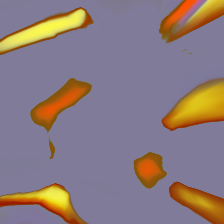

==== (150, 0) ====


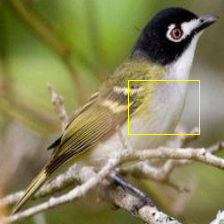

step: 0/500, loss: -0.11638325452804565


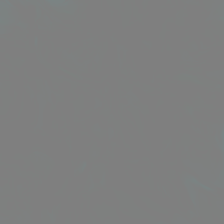

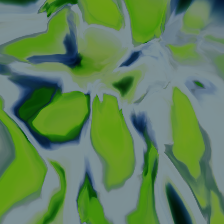

==== (199, 0) ====


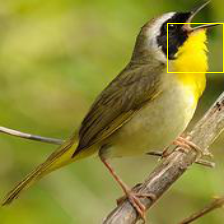

step: 0/500, loss: -0.025820886716246605


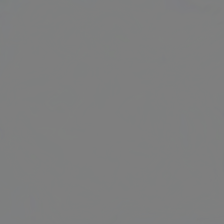

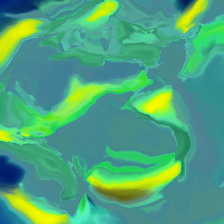

In [10]:
ptypes = [
    (50, 0), (100, 0), (150, 0), (199, 0)
]
ptype_imgs = [
    "051.Horned_Grebe/Horned_Grebe_0072_34497.jpg",
    "101.White_Pelican/White_Pelican_0032_96920.jpg",
    "151.Black_capped_Vireo/Black_Capped_Vireo_0041_797452.jpg",
    "200.Common_Yellowthroat/Common_Yellowthroat_0106_190989.jpg"
]

def loss(model, image, mask):
    output = model(image)[mask]
    return -torch.sum(output)

transforms = []
robustness_transforms = []
gradient_transforms = []
denormalization_transforms = []

generators = []
for p, img in zip(ptypes, ptype_imgs):
    print('====', p, '====')
    img = visualize_real_prototype(model, img, p[0], p[1])
    display(img)
    gen = ImageCPPN(224, normalize=True, num_layers=24, num_hidden_channels=24).to(device)
    generators.append(gen)
    parametrization_transforms = [tfs.Lambda(lambda _: gen().squeeze(0))]
    optimized_input = visualize_prototypes(model=model,
                                        prototypes_list=[p],
                                        loss_agg_fn=loss,
                                        input_tensor=torch.zeros(*size),
                                        optimizer_cls=torch.optim.Adam,
                                        optimizer_parameters=gen.parameters(),
                                        optimizer_kwargs={'lr': 0.001},
                                        optimization_steps=500,
                                        transforms=transforms,
                                        robustness_transforms=robustness_transforms,
                                        parametrization_transforms=parametrization_transforms,
                                        gradient_transforms=gradient_transforms,
                                        denormalization_transforms=denormalization_transforms,
                                        reverse_reversible_robustness_transforms=False,
                                        print_interval=500,
                                        display_interval=500)
    image = gen().squeeze(0)
    display(F.to_pil_image(image))

same as above but 5 layer CPPN

==== (50, 0) ====


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


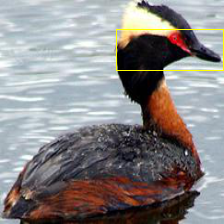

step: 0/500, loss: -0.07712496072053909


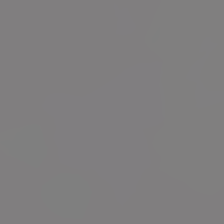

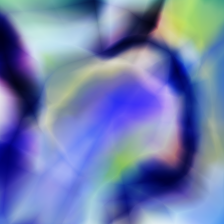

==== (100, 0) ====


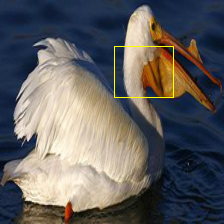

step: 0/500, loss: -0.05832629278302193


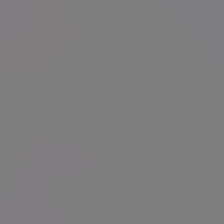

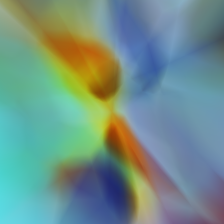

==== (150, 0) ====


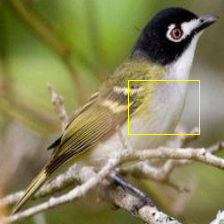

step: 0/500, loss: -0.11638325452804565


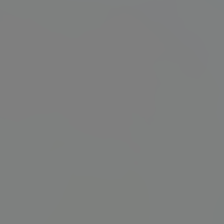

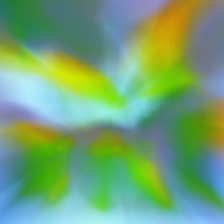

==== (199, 0) ====


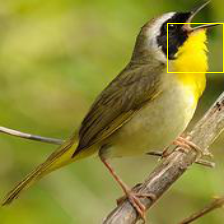

step: 0/500, loss: -0.025820886716246605


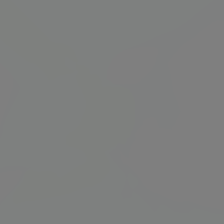

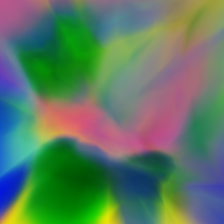

In [12]:
ptypes = [
    (50, 0), (100, 0), (150, 0), (199, 0)
]
ptype_imgs = [
    "051.Horned_Grebe/Horned_Grebe_0072_34497.jpg",
    "101.White_Pelican/White_Pelican_0032_96920.jpg",
    "151.Black_capped_Vireo/Black_Capped_Vireo_0041_797452.jpg",
    "200.Common_Yellowthroat/Common_Yellowthroat_0106_190989.jpg"
]

def loss(model, image, mask):
    output = model(image)[mask]
    return -torch.sum(output)

transforms = []
robustness_transforms = []
gradient_transforms = []
denormalization_transforms = []

generators = []
for p, img in zip(ptypes, ptype_imgs):
    print('====', p, '====')
    img = visualize_real_prototype(model, img, p[0], p[1])
    display(img)
    gen = ImageCPPN(224, normalize=True,  num_layers=5, num_hidden_channels=24).to(device)
    generators.append(gen)
    parametrization_transforms = [tfs.Lambda(lambda _: gen().squeeze(0))]

    mask = get_prototypes_mask_from_prototypes_list(model, ptypes) 
    optimized_input = visualize_prototypes(model=model,
                                        prototypes_list=[p],
                                        loss_agg_fn=loss,
                                        input_tensor=torch.zeros(*size),
                                        optimizer_cls=torch.optim.Adam,
                                        optimizer_parameters=gen.parameters(),
                                        optimizer_kwargs={'lr': 0.001},
                                        optimization_steps=500,
                                        transforms=transforms,
                                        robustness_transforms=robustness_transforms,
                                        parametrization_transforms=parametrization_transforms,
                                        gradient_transforms=gradient_transforms,
                                        denormalization_transforms=denormalization_transforms,
                                        reverse_reversible_robustness_transforms=False,
                                        print_interval=500,
                                        display_interval=500)
    image = gen().squeeze(0)
    display(F.to_pil_image(image))

# Fourier space

==== (188, 0) ====


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


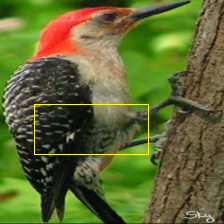

step: 0/500, loss: -0.16294732689857483


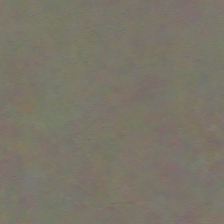

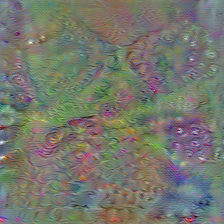

==== (188, 1) ====


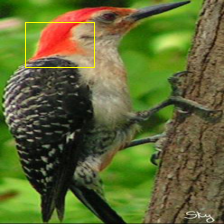

step: 0/500, loss: -0.08759114891290665


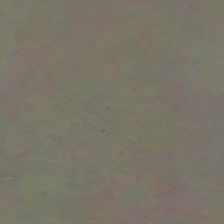

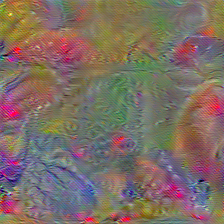

==== (188, 2) ====


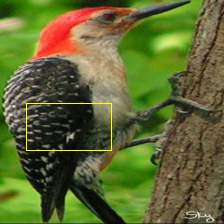

step: 0/500, loss: -0.17780907452106476


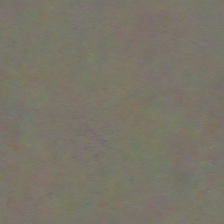

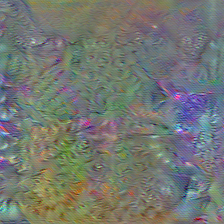

In [13]:
num = 3
ptypes = [(188,i) for i in range(num)]
generators = [FFTGenerator().to(device) for i in range(num)]

def loss(model, image, mask):
    output = model(image)[mask]
    return -torch.mean(output)

transforms = []
robustness_transforms = []
gradient_transforms = []
denormalization_transforms = []

for g, p in zip(generators, ptypes):
    print('====', p, '====')
    img = visualize_real_prototype(model,"189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0002_180879.jpg" , p[0], p[1])
    display(img)
    parametrization_transforms = [tfs.Lambda(lambda _: g().squeeze(0))]
    optimized_input = visualize_prototypes(model=model,
                                        prototypes_list=[p],
                                        loss_agg_fn=loss,
                                        input_tensor=torch.zeros(*size),
                                        optimizer_cls=torch.optim.Adam,
                                        optimizer_parameters=[g.spectrum_tensor],
                                        optimizer_kwargs={'lr': 0.005},
                                        optimization_steps=500,
                                        transforms=transforms,
                                        robustness_transforms=robustness_transforms,
                                        parametrization_transforms=parametrization_transforms,
                                        gradient_transforms=gradient_transforms,
                                        denormalization_transforms=denormalization_transforms,
                                        reverse_reversible_robustness_transforms=False,
                                        print_interval=500,
                                        display_interval=500)
    image = g().squeeze(0)
    display(F.to_pil_image(image))